COVID/images 文件夹: 找到 3616 张图像
Normal/images 文件夹: 找到 10192 张图像
Viral Pneumonia/images 文件夹: 找到 1345 张图像
Lung_Opacity/images 文件夹: 找到 6012 张图像
总共找到 21165 张图像
Epoch 1/10


100%|██████████| 662/662 [00:30<00:00, 21.78it/s]


Generator Loss: -3.4312  Discriminator Loss: -33.1178


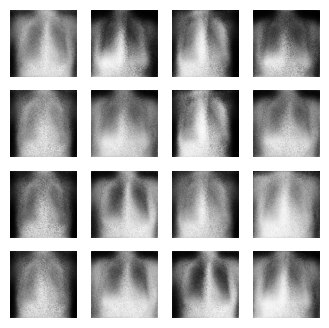

Epoch 2/10


100%|██████████| 662/662 [00:26<00:00, 24.59it/s]


Generator Loss: 0.8732  Discriminator Loss: -11.8729


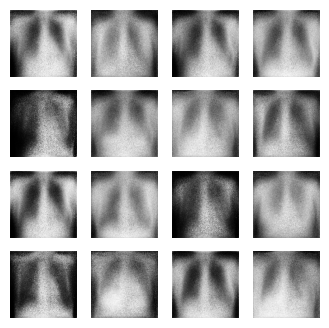

Epoch 3/10


100%|██████████| 662/662 [00:26<00:00, 24.76it/s]


Generator Loss: 1.5600  Discriminator Loss: -8.2096


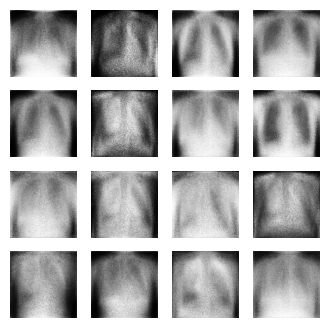

Epoch 4/10


100%|██████████| 662/662 [00:27<00:00, 24.16it/s]


Generator Loss: 2.0423  Discriminator Loss: -5.7467


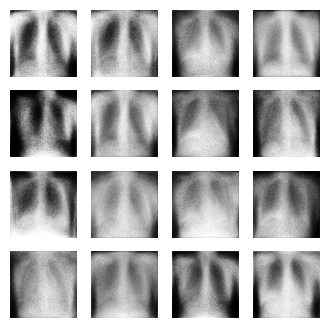

Epoch 5/10


100%|██████████| 662/662 [00:26<00:00, 24.58it/s]


Generator Loss: 1.7973  Discriminator Loss: -5.6911


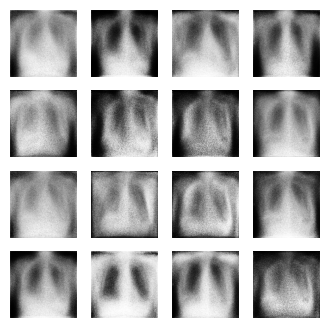

Epoch 6/10


100%|██████████| 662/662 [00:27<00:00, 24.24it/s]


Generator Loss: 1.4919  Discriminator Loss: -3.9273


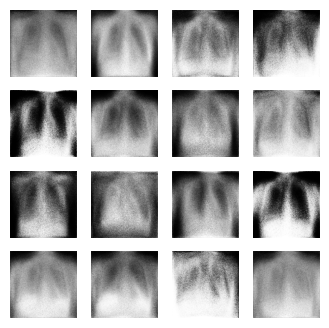

Epoch 7/10


100%|██████████| 662/662 [00:26<00:00, 25.23it/s]


Generator Loss: 2.0452  Discriminator Loss: -3.2066


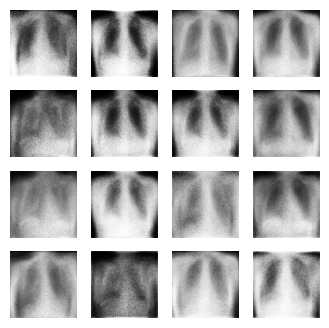

Epoch 8/10


100%|██████████| 662/662 [00:26<00:00, 24.72it/s]


Generator Loss: 1.2851  Discriminator Loss: -2.7685


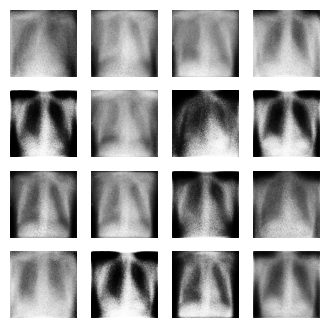

Epoch 9/10


100%|██████████| 662/662 [00:26<00:00, 25.13it/s]


Generator Loss: 1.7953  Discriminator Loss: -2.5875


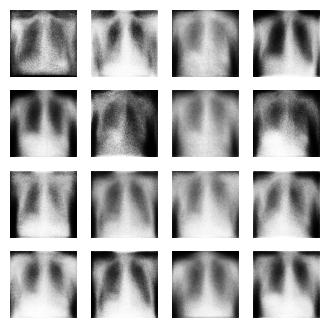

Epoch 10/10


100%|██████████| 662/662 [00:26<00:00, 24.80it/s]


Generator Loss: 1.2812  Discriminator Loss: -2.5735


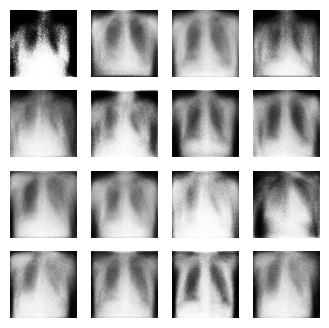

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
NOISE_DIM = 100
LAMBDA_GP = 10.0  
DATA_DIR = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'


def load_images(data_dir):
    categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
    image_paths = []
    for category in categories:
        category_folder = os.path.join(data_dir, category, 'images')
        images = glob(os.path.join(category_folder, '*.png'))
        image_paths.extend(images)
        print(f"{category}/images 文件夹: 找到 {len(images)} 张图像")
    print(f"总共找到 {len(image_paths)} 张图像")
    return image_paths


def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return (image - 127.5) / 127.5 


image_paths = load_images(DATA_DIR)
dataset = (tf.data.Dataset.from_tensor_slices(image_paths)
           .map(lambda x: preprocess_image(x))
           .batch(BATCH_SIZE)
           .shuffle(buffer_size=1000))


def build_generator():
    model = models.Sequential([
        layers.Dense(256, input_shape=(NOISE_DIM,), activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(IMG_SIZE * IMG_SIZE, activation='tanh'),
        layers.Reshape((IMG_SIZE, IMG_SIZE, 1))
    ])
    return model


def build_discriminator():
    model = models.Sequential([
        layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1) 
    ])
    return model


generator = build_generator()
discriminator = build_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = tf.shape(real_images)[0] 
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.)  
    interpolated_images = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        interpolated_output = discriminator(interpolated_images)
    gradients = tape.gradient(interpolated_output, [interpolated_images])[0]
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
    return penalty

@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0] 
    noise = tf.random.normal([batch_size, NOISE_DIM]) 

    # 训练判别器
    with tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gp = gradient_penalty(discriminator, real_images, fake_images)
        disc_loss = discriminator_loss(real_output, fake_output) + LAMBDA_GP * gp

    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # 训练生成器
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        gen_loss = generator_loss(fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

    return gen_loss, disc_loss


def generate_and_save_images(epoch):
    noise = tf.random.normal([16, NOISE_DIM])
    fake_images = generator(noise, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f"epoch_{epoch:04d}_generated.png")
    plt.show()


def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        gen_losses = []
        disc_losses = []
        for image_batch in tqdm(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"Generator Loss: {np.mean(gen_losses):.4f}  Discriminator Loss: {np.mean(disc_losses):.4f}")

        generate_and_save_images(epoch + 1)


train(dataset, EPOCHS)
